# Project Title:
# Driving Behaviour Pattern Analysis in Telematics Data Using K-Means Clustering

**Team Members:**
Ibrahim Balogun, Koti Reddy Kommireddy, Thuvarakan Mathipalan, Rahul Saini

**Submission Date:**
April 16th, 2025


In [ ]:
import pandas as pd
from tabulate import tabulate

#load telematics data
df = pd.read_csv("G9WT3MTW2E7Z.csv")
print(tabulate(df.head(), headers="keys", tablefmt="fancy_grid"))


╒════╤══════════╤═════════════════╤════════════╤═════════════════╤═════════════════╤═══════════════════╤════════════╤════════════════╤════════════╤═════════════╤═══════════╤═════════╕
│    │       id │ telematics_id   │   h2gen_id │ timestamp       │   fuel_lifetime │   fuel_telematics │   odometer │   engine_speed │   latitude │   longitude │   runtime │   speed │
╞════╪══════════╪═════════════════╪════════════╪═════════════════╪═════════════════╪═══════════════════╪════════════╪════════════════╪════════════╪═════════════╪═══════════╪═════════╡
│  0 │ 70787948 │ G9WT3MTW2E7Z    │      11428 │ 2023-12-01 8:21 │              -1 │                -1 │         -1 │             -1 │     50.572 │     2.36416 │       nan │       0 │
├────┼──────────┼─────────────────┼────────────┼─────────────────┼─────────────────┼───────────────────┼────────────┼────────────────┼────────────┼─────────────┼───────────┼─────────┤
│  1 │ 70787949 │ G9WT3MTW2E7Z    │      11428 │ 2023-12-01 8:23 │              

# Data Preprocessing

In [ ]:
import numpy as np

#droping columns
columns_to_drop = ["telematics_id", "h2gen_id", "fuel_lifetime", "fuel_telematics", "engine_speed", "runtime"]
df = df.drop(columns=columns_to_drop)

#converting timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

#handling missing values (-1 to NaN)
df["odometer"] = df["odometer"].replace(-1, np.nan)

#droping rows with missing speed, timestamp, latitude, longitude
df = df.dropna(subset=["speed", "timestamp", "latitude", "longitude"])
print(f"After dropping NaN speeds/locations: {len(df)} rows")
print(tabulate(df.head(), headers="keys", tablefmt="fancy_grid"))


After dropping NaN speeds/locations: 211834 rows
╒════╤══════════╤═════════════════════╤════════════╤════════════╤═════════════╤═════════╕
│    │       id │ timestamp           │   odometer │   latitude │   longitude │   speed │
╞════╪══════════╪═════════════════════╪════════════╪════════════╪═════════════╪═════════╡
│  0 │ 70787948 │ 2023-12-01 08:21:00 │        nan │     50.572 │     2.36416 │       0 │
├────┼──────────┼─────────────────────┼────────────┼────────────┼─────────────┼─────────┤
│  1 │ 70787949 │ 2023-12-01 08:23:00 │        nan │     50.572 │     2.36416 │       0 │
├────┼──────────┼─────────────────────┼────────────┼────────────┼─────────────┼─────────┤
│  2 │ 70787950 │ 2023-12-01 08:25:00 │        nan │     50.572 │     2.36416 │       0 │
├────┼──────────┼─────────────────────┼────────────┼────────────┼─────────────┼─────────┤
│  3 │ 70787951 │ 2023-12-01 08:26:00 │        nan │     50.572 │     2.36416 │       0 │
├────┼──────────┼─────────────────────┼────────────

In [ ]:
#handling duplicate timestamps
df_avg = df.groupby("timestamp").agg({
    "speed": "mean",
    "latitude": "first",
    "longitude": "first",
    "odometer": "first"
}).reset_index()
print(f"After averaging same timestamps: {len(df_avg)} rows")
print(tabulate(df_avg.head(), headers="keys", tablefmt="fancy_grid"))


After averaging same timestamps: 44296 rows
╒════╤═════════════════════╤═════════╤════════════╤═════════════╤════════════╕
│    │ timestamp           │   speed │   latitude │   longitude │   odometer │
╞════╪═════════════════════╪═════════╪════════════╪═════════════╪════════════╡
│  0 │ 2023-12-01 08:21:00 │       0 │     50.572 │     2.36416 │        nan │
├────┼─────────────────────┼─────────┼────────────┼─────────────┼────────────┤
│  1 │ 2023-12-01 08:23:00 │       0 │     50.572 │     2.36416 │        nan │
├────┼─────────────────────┼─────────┼────────────┼─────────────┼────────────┤
│  2 │ 2023-12-01 08:25:00 │       0 │     50.572 │     2.36416 │        nan │
├────┼─────────────────────┼─────────┼────────────┼─────────────┼────────────┤
│  3 │ 2023-12-01 08:26:00 │       0 │     50.572 │     2.36416 │        nan │
├────┼─────────────────────┼─────────┼────────────┼─────────────┼────────────┤
│  4 │ 2023-12-01 08:28:00 │       0 │     50.572 │     2.36416 │        nan │
╘════╧══

In [ ]:
#segmenting into driving sessions (time gap > 5 min)
df_avg["time_diff"] = df_avg["timestamp"].diff().dt.total_seconds().fillna(0)
df_avg["session"] = (df_avg["time_diff"] > 300).cumsum()
print(f"Number of sessions: {df_avg['session'].nunique()}")


Number of sessions: 886


In [ ]:
!pip install haversine

In [ ]:
from haversine import haversine

#calculating features per session
features = []
for session_id, session_df in df_avg.groupby("session"):

    #avg speed (moving average)
    moving_speeds = session_df["speed"][session_df["speed"] > 0]
    if len(moving_speeds) > 0:
        avg_speed = moving_speeds.mean()
    else:
        avg_speed = 0

    #max speed
    max_speed = session_df["speed"].max()

    #avg acceleration
    speeds = session_df["speed"].values
    times = (session_df["timestamp"] - session_df["timestamp"].iloc[0]).dt.total_seconds().values
    accel = []
    for i in range(1, len(speeds)):
        delta_speed = speeds[i] - speeds[i-1]
        delta_time = times[i] - times[i-1]
        if delta_time > 0:
            accel.append(delta_speed / delta_time)
    avg_accel = np.mean(np.abs(accel)) if accel else 0

    #distance (using odometer or Haversine)
    if session_df["odometer"].isnull().sum() == 0:
        distance = session_df["odometer"].iloc[-1] - session_df["odometer"].iloc[0]
    else:
        distance = 0
        for i in range(1, len(session_df)):
            coord1 = (session_df["latitude"].iloc[i-1], session_df["longitude"].iloc[i-1])
            coord2 = (session_df["latitude"].iloc[i], session_df["longitude"].iloc[i])
            distance += haversine(coord1, coord2)

    #idle fraction
    idle_fraction = (session_df["speed"] == 0).mean()

    features.append([avg_speed, max_speed, avg_accel, distance, idle_fraction])
    print(f"Session {session_id}: Avg_Speed={avg_speed:.2f}, Max_Speed={max_speed:.2f}, Avg_Accel={avg_accel:.2f}, Distance={distance:.2f}, Idle_Fraction={idle_fraction:.2f}")


Session 0: Avg_Speed=0.00, Max_Speed=0.00, Avg_Accel=0.00, Distance=0.00, Idle_Fraction=1.00
Session 1: Avg_Speed=35.46, Max_Speed=81.00, Avg_Accel=0.20, Distance=8.75, Idle_Fraction=0.32
Session 2: Avg_Speed=37.09, Max_Speed=53.29, Avg_Accel=0.11, Distance=5.45, Idle_Fraction=0.53
Session 3: Avg_Speed=19.90, Max_Speed=44.20, Avg_Accel=0.09, Distance=8.91, Idle_Fraction=0.57
Session 4: Avg_Speed=28.11, Max_Speed=68.40, Avg_Accel=0.18, Distance=8.26, Idle_Fraction=0.30
Session 5: Avg_Speed=42.86, Max_Speed=65.00, Avg_Accel=0.14, Distance=9.12, Idle_Fraction=0.35
Session 6: Avg_Speed=28.21, Max_Speed=55.00, Avg_Accel=0.15, Distance=4.54, Idle_Fraction=0.37
Session 7: Avg_Speed=21.25, Max_Speed=49.00, Avg_Accel=0.11, Distance=0.88, Idle_Fraction=0.64
Session 8: Avg_Speed=0.97, Max_Speed=1.50, Avg_Accel=0.01, Distance=0.02, Idle_Fraction=0.00
Session 9: Avg_Speed=21.60, Max_Speed=38.00, Avg_Accel=0.09, Distance=5.73, Idle_Fraction=0.45
Session 10: Avg_Speed=37.42, Max_Speed=88.00, Avg_Acce

In [ ]:
#creating features dataframe
features_df = pd.DataFrame(features, columns=["Avg_Speed", "Max_Speed", "Avg_Accel", "Distance", "Idle_Fraction"])
print(f"Features DataFrame: {len(features_df)} rows")
print(tabulate(features_df.head(), headers="keys", tablefmt="fancy_grid"))


Features DataFrame: 886 rows
╒════╤═════════════╤═════════════╤═════════════╤════════════╤═════════════════╕
│    │   Avg_Speed │   Max_Speed │   Avg_Accel │   Distance │   Idle_Fraction │
╞════╪═════════════╪═════════════╪═════════════╪════════════╪═════════════════╡
│  0 │      0      │      0      │   0         │    0       │        1        │
├────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────────┤
│  1 │     35.4563 │     81      │   0.197317  │    8.75338 │        0.318182 │
├────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────────┤
│  2 │     37.0851 │     53.2857 │   0.107696  │    5.45133 │        0.526316 │
├────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────────┤
│  3 │     19.9008 │     44.2    │   0.0928542 │    8.90672 │        0.573529 │
├────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────────┤
│  4 │     28.1107 │     68.4    │   0.177418  │    8.26095 │        0.296296 │
╘════╧═════

In [ ]:
from sklearn.preprocessing import StandardScaler

#standardizing features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)


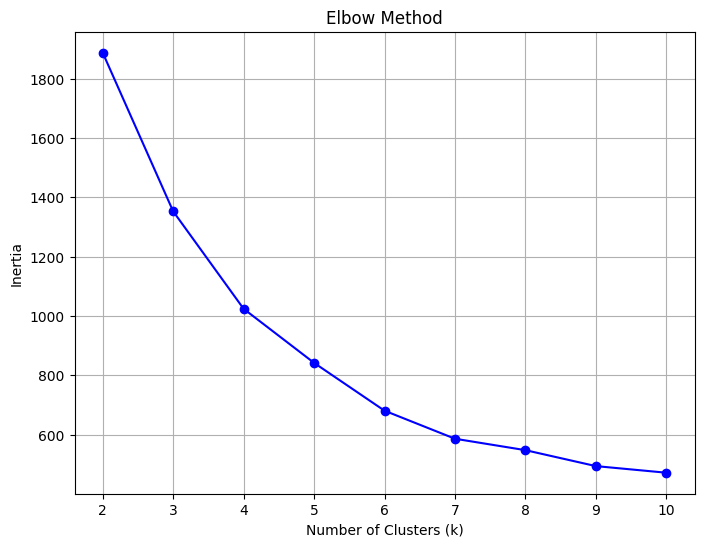

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#computing inertia and silhouette scores for k=2 to 10
inertia = []
silhouette_scores = []

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

#plot inertia - elbow method
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker="o", color="blue")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


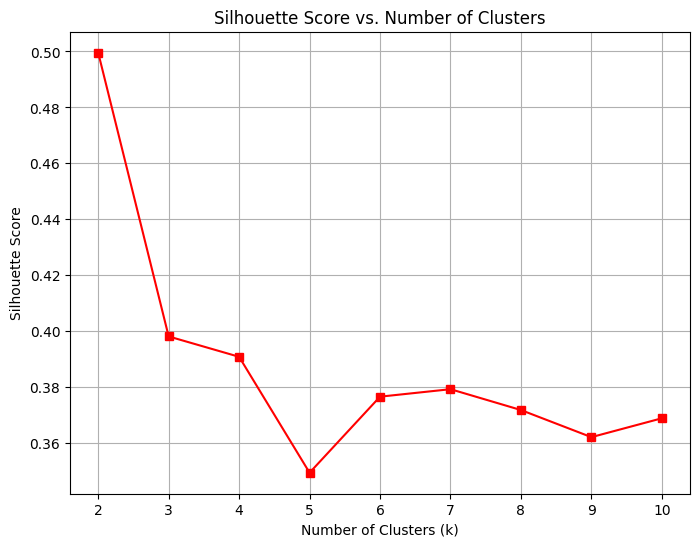

In [ ]:
#plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker="s", color="red")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()


**Why Choose k = 3**

•	Silhouette score at k=3 is still strong, even if not the maximum.

•	Elbow method clearly shows a "bend" at k=3, indicating a good balance between accuracy and simplicity.

•	Choosing k = 3 gives a reasonable cluster structure that is both well-separated and practical for interpretation or action.


# Applying K-Means clustering (k=3)

In [ ]:
#applying K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=101)
features_df["Cluster"] = kmeans.fit_predict(scaled_features)


In [ ]:
#mapping clusters to desired labels
cluster_map = {
    0: "Fast-paced and Long-Haul Driving",
    1: "Slow and Idle-Prone",
    2: "Moderate and Mixed-Pattern"
}

features_df["Cluster_Label"] = features_df["Cluster"].map(cluster_map)

#displaying results
print("\nFinal Clusters:")
print(tabulate(features_df.head(), headers="keys", tablefmt="fancy_grid"))



Final Clusters:
╒════╤═════════════╤═════════════╤═════════════╤════════════╤═════════════════╤═══════════╤══════════════════════════════════╕
│    │   Avg_Speed │   Max_Speed │   Avg_Accel │   Distance │   Idle_Fraction │   Cluster │ Cluster_Label                    │
╞════╪═════════════╪═════════════╪═════════════╪════════════╪═════════════════╪═══════════╪══════════════════════════════════╡
│  0 │      0      │      0      │   0         │    0       │        1        │         1 │ Slow and Idle-Prone              │
├────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────────┼───────────┼──────────────────────────────────┤
│  1 │     35.4563 │     81      │   0.197317  │    8.75338 │        0.318182 │         0 │ Fast-paced and Long-Haul Driving │
├────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────────┼───────────┼──────────────────────────────────┤
│  2 │     37.0851 │     53.2857 │   0.107696  │    5.45133 │        0.526316 │         2 │ Mo

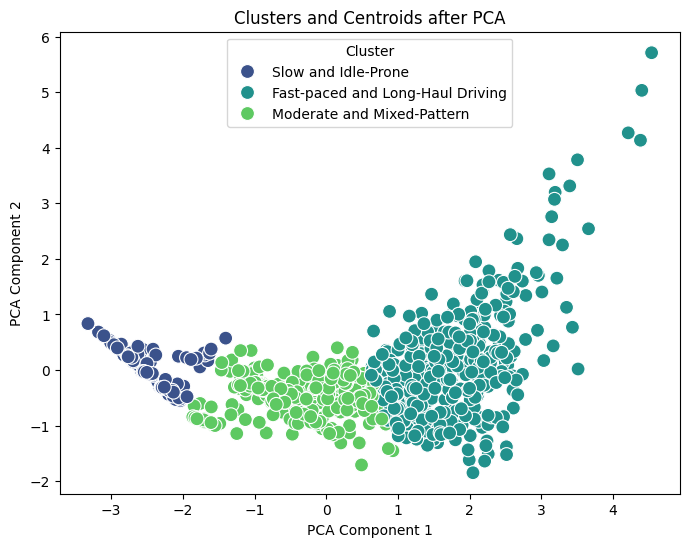

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

features_df["PCA1"] = pca_components[:, 0]
features_df["PCA2"] = pca_components[:, 1]

#scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features_df, x="PCA1", y="PCA2", hue="Cluster_Label", palette="viridis", s=100)
plt.title("Clusters and Centroids after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", loc="upper center")
plt.show()


# **Interpretation of Clusters**

**Cluster 0:** Drivers in this group maintain consistently high speeds with minimal idling, suggesting long-distance or highway travel. While efficient in terms of motion, these drivers might be at higher risk for speeding-related incidents or vehicle wear due to sustained high speeds and potentially aggressive acceleration habits.

**Cluster 1:** Drivers in this group operate at low speeds and exhibit a high proportion of idle time. This may suggest cautious driving, frequent stops, or congestion-heavy routes. While potentially lower-risk from a safety standpoint, it could indicate inefficient vehicle usage.

**Cluster 2:** This group displays balanced driving behaviour, with moderate speeds, varied acceleration, and some idling. It reflects typical urban or suburban driving, where traffic signals, stop-and-go conditions, or route variability influence patterns.


# References

•	https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/  

•	https://scikitlearn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

•	https://pypi.org/project/haversine/

•	https://365datascience.com/tutorials/python-tutorials/pca-k-means/
